# Batina Advanced Weight Recovery

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.

In [1]:
import pathlib
TEST_RESULT_DIR = './results'

pathlib.Path(TEST_RESULT_DIR).mkdir(parents=True, exist_ok=True) 

In [2]:
import sys
sys.path.append("../")

from pybatina.utils import *
from pybatina.advanced_weight_recovery import *

In [3]:
guess_range=(-5.0, 5.0)

## Recover multiple secret numbers

In [4]:
SECRET_VALUE='secret value'
GUESSED_VALUE = 'guessed value'
CORRELATION='correlation'
df_index = [SECRET_VALUE, GUESSED_VALUE, CORRELATION]

In [5]:
precision = 1e-3
n_secret_numbers = 5000
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
)).astype(np.float32)
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (5000,)


## Batina without noise

### load existing DB

In [6]:
# read the existing data
from os import path
try:
    fname = path.join(TEST_RESULT_DIR, 'advanced_batina_results.csv')
    last_df = pd.read_csv(fname, index_col=0)
    print('read results in %s' % fname)
    print('number of weight values', len(last_df[SECRET_VALUE].unique()))
except FileNotFoundError:
    last_df = pd.DataFrame()
    pass

#last_df = pd.DataFrame()
batina_results = last_df

read results in ./results/advanced_batina_results.csv
number of weight values 717


### main process

In [7]:
%%time 
wr = AdvancedWeightRecovery(guess_range=guess_range, number_of_best_candidates=20)
for value in secret_numbers:
    try:
        if value in batina_results[SECRET_VALUE].unique():
            continue
    except KeyError:
        pass
        
    secret_hamming_weight_set = [np.vectorize(hamming_weight)(input_values * value) for input_values in wr.input_value_set]    
    s = wr.recover_weight(secret_hamming_weight_set)    
    s.name = CORRELATION
    df = pd.DataFrame(s).reset_index().rename(columns={'index': GUESSED_VALUE})
    df[SECRET_VALUE] = value
    batina_results = pd.concat([batina_results, df], axis=0, ignore_index=True)

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
../pybatina/advanced_weight_recovery.py:179: RuntimeWarning: invalid value encountered in greater_equal
  guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= self.guess_range[0], guess_numbers <= self.guess_range[1]))]
../pybatina/advanced_weight_recovery.py:179: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= self.guess_range[0], guess_numbers <= self.guess_range[1]))]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)
<timed exec>:9: RuntimeWarning: overflow encountered in multiply


KeyboardInterrupt: 

In [8]:
batina_results

,guessed value,correlation,secret value
0,-0.294298,1.000000,-0.294298
1,-0.294298,1.000000,-0.294298
2,-0.294298,1.000000,-0.294298
3,-0.294298,0.999404,-0.294298
4,-0.294298,0.999404,-0.294298
...,...,...,...
16572,-1.059873,0.854836,1.059872
16573,-1.059872,0.851465,1.059872
16574,-1.059872,0.851465,1.059872
16575,-1.059872,0.851465,1.059872


### merge and save DB

In [9]:
print('number of weight values', len(batina_results[SECRET_VALUE].unique()))
batina_results.to_csv(fname)
print('save results in %s' % fname)

number of weight values 722
save results in ./results/advanced_batina_results.csv


### Statistics

In [10]:
ERROR = 'error'
def statistics(df):
    dft = df[[SECRET_VALUE, GUESSED_VALUE, CORRELATION]].astype(dtype=np.float64)
    dft[ERROR] = np.abs((dft[GUESSED_VALUE] - dft[SECRET_VALUE])/dft[SECRET_VALUE])    
    best_corr = dft.loc[dft.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
    best_err = dft.loc[dft.groupby(SECRET_VALUE)[ERROR].idxmin()]
    return best_corr.T, best_err.T

In [11]:
batina_best_corr, batina_best_err = statistics(batina_results)

In [12]:
study_score = batina_best_corr
(study_score.T[ERROR] < 1e-3).value_counts()

True    722
Name: error, dtype: int64

In [13]:
error_sorted = study_score.T.sort_values(ERROR, ascending=False)
error_sorted[:20]

,secret value,guessed value,correlation,error
10497,-0.399833,-0.399990,1.000000,3.917662e-04
2720,0.903020,0.903219,1.000000,2.209878e-04
11217,0.749821,0.749939,1.000000,1.577118e-04
4360,-1.156233,-1.156258,0.950793,2.103269e-05
7099,-0.583337,-0.583349,1.000000,2.064009e-05
2780,0.295757,0.295759,1.000000,6.449046e-06
10857,-3.972645,-3.972650,1.000000,1.440362e-06
3880,2.860775,2.860772,1.000000,1.250108e-06
12437,-4.113654,-4.113658,1.000000,1.043242e-06
13917,-1.098231,-1.098232,1.000000,9.769200e-07


In [14]:
error_sorted.iloc[0][SECRET_VALUE]

-0.3998328745365143

save results in ./results/advanced_batina_graphs.jpg


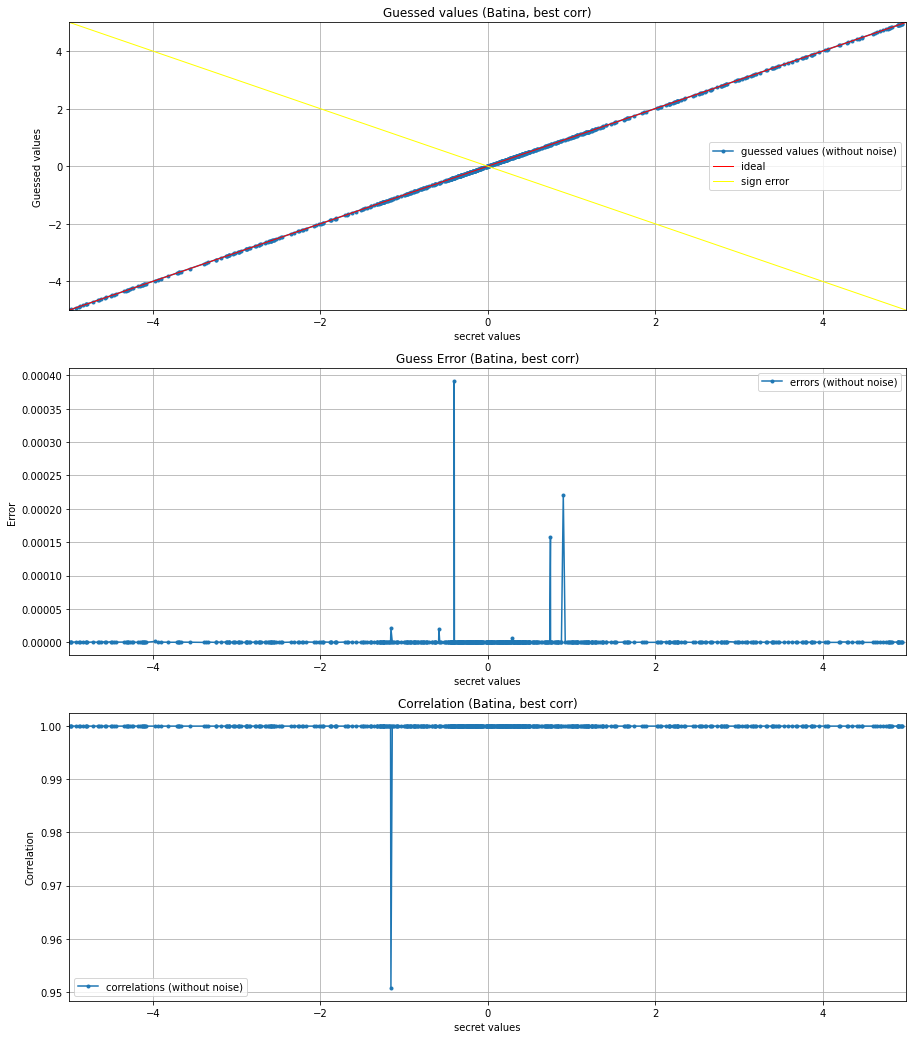

In [19]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))
df = batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='guessed values (without noise)')
ax[0].plot(guess_range, guess_range, linewidth=1, label='ideal', color='red')
ax[0].plot([guess_range[1], guess_range[0]], guess_range, linewidth=1, label='sign error', color='yellow')
ax[0].set_ylim(np.min(guess_range), np.max(guess_range))

ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (Batina, best corr)')

df = batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='errors (without noise)')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (Batina, best corr)')

df = batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='correlations (without noise)')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (Batina, best corr)')

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')
    a.set_xlim(np.min(guess_range), np.max(guess_range))

from os import path
fig_fname = path.join(TEST_RESULT_DIR, 'advanced_batina_graphs.jpg')
plt.savefig(fig_fname)
print('save results in %s' % fig_fname)
plt.show()